In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense
from sklearn.model_selection import train_test_split

### Read data

In [11]:
# import the ICU Molecular Biology (Promoter Gene Sequences) Data Set
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/molecular-biology/promoter-gene-sequences/promoters.data"

### Data preprocessing

In [12]:
names = ["Class", "id", "Sequence"]
data = pd.read_csv(url, names = names)

In [13]:
data.head(5)

,Class,id,Sequence
0,+,S10,\t\ttactagcaatacgcttgcgttcggtggttaagtatgtataat...
1,+,AMPC,\t\ttgctatcctgacagttgtcacgctgattggtgtcgttacaat...
2,+,AROH,\t\tgtactagagaactagtgcattagcttatttttttgttatcat...
3,+,DEOP2,\taattgtgatgtgtatcgaagtgtgttgcggagtagatgttagaa...
4,+,LEU1_TRNA,\ttcgataattaactattgacgaaaagctgaaaaccactagaatgc...


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Class     106 non-null    object
 1   id        106 non-null    object
 2   Sequence  106 non-null    object
dtypes: object(3)
memory usage: 2.6+ KB


In [7]:
# Building our Dataset by creating a custom Pandas Dataframe
# Each column in a Dataframe is called a Series. 
classes = data.loc[:,"Class"].unique()

In [8]:
classes

array(['+', '-'], dtype=object)

In [9]:
data.groupby('Class').count()

,id,Sequence
Class,,
+,53,53
-,53,53


### WordMap analysis

In [ ]:
#! pip install wordcloud

In [15]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud
import re
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to C:\Users\ASUS
[nltk_data]     TUF\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\ASUS
[nltk_data]     TUF\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\ASUS
[nltk_data]     TUF\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [16]:
data['Class'].unique()

array(['+', '-'], dtype=object)

In [28]:
lm= WordNetLemmatizer()

def text_transformation(data: pd.DataFrame) -> list:
        corpus = []
        for item in data:
            new_item = re.sub('[^a-zA-Z]',' ',str(item))
            new_item = new_item.lower()
            new_item = new_item.split()
            new_item = [lm.lemmatize(word) for word in new_item if word not in set(stopwords.words('english'))]
            corpus.append(' '.join(str(x) for x in new_item))
        return corpus

def word_cloud_generate(classes : str) -> plt:
    df_test= data[data['Class']==classes][['Sequence']]
    df_test['Sequence']= df_test['Sequence'].astype(str)
    df_test['Sequence']= df_test['Sequence'].str.lower()
    corpus = text_transformation(df_test['Sequence'])
    word_cloud = ''
    for row in corpus :
        for word in row:
            word_cloud += "".join(word)
    wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(word_cloud)
    
    return wordcloud

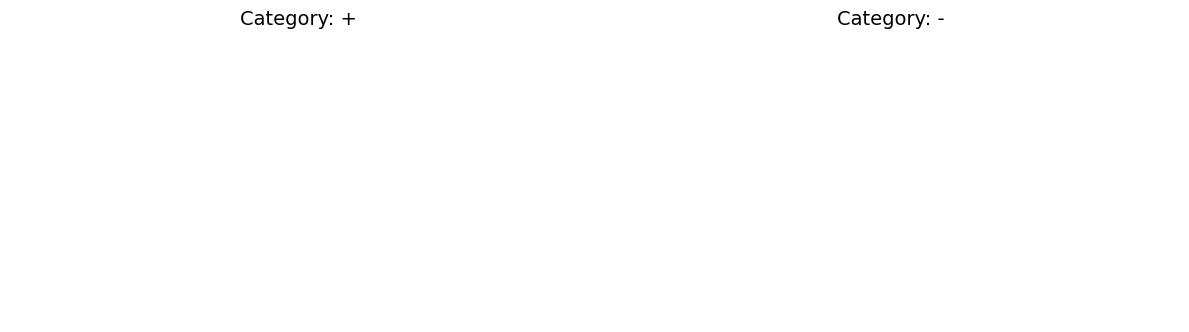

In [29]:
# Get unique categories
classes = data['Class'].unique()
n = len(classes)

# Set up subplots grid (auto-adjusted rows/cols)
cols = 2
rows = (n + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 6 * rows))
axes = axes.flatten()  # flatten in case of 1D row

for i, cat in enumerate(classes):
    wc = word_cloud_generate(cat)
    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].set_title(f"Category: {cat}", fontsize=14)
    axes[i].axis('off')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [65]:
# === Clean DNA sequences
def clean_sequence(seq):
    return ''.join(seq.strip().replace('\t', '').lower())

data['Sequence'] = data['Sequence'].apply(clean_sequence)

# === Define DNA vocabulary
vocab = {'a': 1, 't': 2, 'c': 3, 'g': 4, 'n': 5}
vocab_size = len(vocab) + 1  # 0 for padding

# === Encode sequences
def encode_sequence(seq):
    return [vocab.get(char, 0) for char in seq]

In [66]:
data['encoded'] = data['Sequence'].apply(encode_sequence)
X = pad_sequences(data['encoded'], padding='post')

# === Encode class labels: '+' -> 1, '-' -> 0
data['Class'] = data['Class'].map({'+': 1, '-': 0})
y = np.array(data['Class'])

In [68]:
# === Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === RNN Model
def build_rnn_model(input_length, vocab_size):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=16, input_length=input_length),
        SimpleRNN(64),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [69]:
# === LSTM Model
def build_lstm_model(input_length, vocab_size):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=16, input_length=input_length),
        LSTM(64),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [70]:
input_length = X.shape[1]

# === Train RNN
print("Training RNN model...")
rnn_model = build_rnn_model(input_length, vocab_size)
rnn_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=1)

# === Train LSTM
print("Training LSTM model...")
lstm_model = build_lstm_model(input_length, vocab_size)
lstm_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=1)

# === Predict Class (+ or -)
def preprocess_sequence(seq, max_len):
    seq = clean_sequence(seq)
    encoded = encode_sequence(seq)
    padded = pad_sequences([encoded], maxlen=max_len, padding='post')
    return padded

sample_seq = data['Sequence'].iloc[0]
x_input = preprocess_sequence(sample_seq, input_length)

# === Predict with RNN
rnn_pred = rnn_model.predict(x_input)[0][0]
rnn_class = '+' if rnn_pred >= 0.5 else '-'

# === Predict with LSTM
lstm_pred = lstm_model.predict(x_input)[0][0]
lstm_class = '+' if lstm_pred >= 0.5 else '-'

print("Original Sequence:", sample_seq)
print("RNN Prediction Score:", rnn_pred, "Class:", rnn_class)
print("LSTM Prediction Score:", lstm_pred, "Class:", lstm_class)

Training RNN model...
Epoch 1/10


C:\Users\ASUS TUF\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.4825 - loss: 0.6939 - val_accuracy: 0.6364 - val_loss: 0.6464
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8190 - loss: 0.6155 - val_accuracy: 0.6818 - val_loss: 0.6054
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8069 - loss: 0.5494 - val_accuracy: 0.6364 - val_loss: 0.5971
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7913 - loss: 0.5412 - val_accuracy: 0.5909 - val_loss: 0.6062
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7814 - loss: 0.5137 - val_accuracy: 0.7273 - val_loss: 0.5944
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8462 - loss: 0.4744 - val_accuracy: 0.6364 - val_loss: 0.5650
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8328 - loss: 0.4728 - val_accuracy: 0.7727 - val_loss: 0.5424
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8917 - loss: 0.4327 - val_accuracy: 0.7727 - val_loss: 0.5186
Epoch 9/10

### LSTM 

#### Data structure

In [30]:
vpcap_size = 1000
dim = 16
max_length = 120
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Class     106 non-null    object
 1   id        106 non-null    object
 2   Sequence  106 non-null    object
dtypes: object(3)
memory usage: 2.6+ KB


In [32]:
stop_words = set(stopwords.words('english'))
sentences = []
labels = []

def df_remove_stopwords(text: str) -> str:
    
    for word in stop_words:
        token= ' '+ word + ' '
        text = text.replace(token,' ')
    return text

labels = data['Class'].to_list()
sentences = data['Sequence'].astype(str).apply(df_remove_stopwords).to_list()
    

In [33]:
len(labels)
len(sentences)

106

In [34]:
labels

['+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '+',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-',
 '-']

In [35]:
sentences

['\t\ttactagcaatacgcttgcgttcggtggttaagtatgtataatgcgcgggcttgtcgt',
 '\t\ttgctatcctgacagttgtcacgctgattggtgtcgttacaatctaacgcatcgccaa',
 '\t\tgtactagagaactagtgcattagcttatttttttgttatcatgctaaccacccggcg',
 '\taattgtgatgtgtatcgaagtgtgttgcggagtagatgttagaatactaacaaactc',
 '\ttcgataattaactattgacgaaaagctgaaaaccactagaatgcgcctccgtggtag',
 '\taggggcaaggaggatggaaagaggttgccgtataaagaaactagagtccgtttaggt',
 '\t\tcagggggtggaggatttaagccatctcctgatgacgcatagtcagcccatcatgaat',
 '\t\ttttctacaaaacacttgatactgtatgagcatacagtataattgcttcaacagaaca',
 '\t\tcgacttaatatactgcgacaggacgtccgttctgtgtaaatcgcaatgaaatggttt',
 '\tttttaaatttcctcttgtcaggccggaataactccctataatgcgccaccactgaca',
 '\tgcaaaaataaatgcttgactctgtagcgggaaggcgtattatgcacaccccgcgccg',
 '\tcctgaaattcagggttgactctgaaagaggaaagcgtaatatacgccacctcgcgac',
 '\tgatcaaaaaaatacttgtgcaaaaaattgggatccctataatgcgcctccgttgaga',
 '\tctgcaatttttctattgcggcctgcggagaactccctataatgcgcctccatcgaca',
 '\ttttatatttttcgcttgtcaggccggaataactccctataatgcgccaccactgaca',
 '\taagcaaagaaatgcttgactctgt

#### Data split

In [63]:
train_size = int(len(labels)*training_portion)
train_sentences = sentences[0:train_size]
train_labels = labels[0:train_size]
test_sentences = sentences[train_size:]
test_labels = labels[train_size:]

In [62]:
train_labels

array(['+'], dtype='<U1')

#### Tokenizer and indexes

In [37]:
from tensorflow.keras.preprocessing.text import Tokenizer


In [38]:
sentences_tokenizer =  Tokenizer(num_words = vpcap_size, oov_token=oov_tok)
sentences_tokenizer.fit_on_texts(train_sentences)
word_index= sentences_tokenizer.word_index 

train_sentences_sequences = sentences_tokenizer.texts_to_sequences(train_sentences)
test_sentences_sequences = sentences_tokenizer.texts_to_sequences(test_sentences)


In [39]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_labels_sequences = label_encoder.fit_transform(train_labels)
test_labels_sequences = label_encoder.fit_transform(test_labels)

In [40]:
len(test_labels_sequences)

22

#### Pad_sequences

In [41]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [42]:
train_padded = pad_sequences(train_sentences_sequences, maxlen=max_length, padding=padding_type)
test_padded = pad_sequences(test_sentences_sequences, maxlen=max_length, padding=padding_type)

#### Build The LSTM Model

In [43]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vpcap_size, dim),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(LSTM(dim)),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary output
])

model.compile(
    loss='binary_crossentropy',     # Binary classification loss
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [44]:
num_epochs = 50
history = model.fit(train_padded, train_labels_sequences, epochs=num_epochs, validation_data=(test_padded, test_labels_sequences), verbose=2)

Epoch 1/50
3/3 - 4s - 1s/step - accuracy: 0.6310 - loss: 0.6868 - val_accuracy: 1.0000 - val_loss: 0.6535
Epoch 2/50
3/3 - 0s - 71ms/step - accuracy: 0.6310 - loss: 0.6819 - val_accuracy: 1.0000 - val_loss: 0.6181
Epoch 3/50
3/3 - 0s - 59ms/step - accuracy: 0.6310 - loss: 0.6743 - val_accuracy: 1.0000 - val_loss: 0.5810
Epoch 4/50
3/3 - 0s - 44ms/step - accuracy: 0.6310 - loss: 0.6692 - val_accuracy: 1.0000 - val_loss: 0.5497
Epoch 5/50
3/3 - 0s - 47ms/step - accuracy: 0.6310 - loss: 0.6614 - val_accuracy: 1.0000 - val_loss: 0.5263
Epoch 6/50
3/3 - 0s - 42ms/step - accuracy: 0.6310 - loss: 0.6593 - val_accuracy: 1.0000 - val_loss: 0.4994
Epoch 7/50
3/3 - 0s - 39ms/step - accuracy: 0.6310 - loss: 0.6572 - val_accuracy: 1.0000 - val_loss: 0.4757
Epoch 8/50
3/3 - 0s - 40ms/step - accuracy: 0.6310 - loss: 0.6570 - val_accuracy: 1.0000 - val_loss: 0.4530
Epoch 9/50
3/3 - 0s - 47ms/step - accuracy: 0.6310 - loss: 0.6578 - val_accuracy: 1.0000 - val_loss: 0.4342
Epoch 10/50
3/3 - 0s - 42ms/st

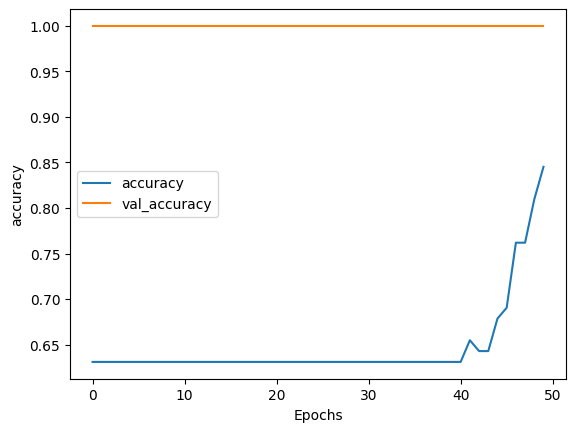

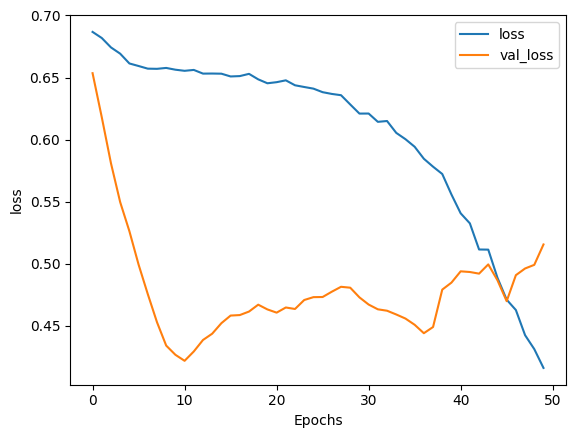

In [45]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [46]:
# Get final evaluation
loss, accuracy = model.evaluate(test_padded, test_labels_sequences, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test Loss: 0.5156
Test Accuracy: 1.0000


In [53]:
data['Sequence'][101]

'\t\tcctcaatggcctctaaacgggtcttgaggggttttttgctgaaaggaggaactatat'

In [52]:
data

,Class,id,Sequence
0,+,S10,\t\ttactagcaatacgcttgcgttcggtggttaagtatgtataat...
1,+,AMPC,\t\ttgctatcctgacagttgtcacgctgattggtgtcgttacaat...
2,+,AROH,\t\tgtactagagaactagtgcattagcttatttttttgttatcat...
3,+,DEOP2,\taattgtgatgtgtatcgaagtgtgttgcggagtagatgttagaa...
4,+,LEU1_TRNA,\ttcgataattaactattgacgaaaagctgaaaaccactagaatgc...
...,...,...,...
101,-,799,\t\tcctcaatggcctctaaacgggtcttgaggggttttttgctga...
102,-,987,\t\tgtattctcaacaagattaaccgacagattcaatctcgtggat...
103,-,1226,\t\tcgcgactacgatgagatgcctgagtgcttccgttactggatt...
104,-,794,\t\tctcgtcctcaatggcctctaaacgggtcttgaggggtttttt...


In [54]:
txt = [data['Sequence'][101]]

seq = sentences_tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
labels = ['+', '-']

print(pred)
print(np.argmax(pred))
print(labels[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[[0.37074]]
0
+


In [38]:
txt = ["Prime Minister Tony Blair is expected to formally announce 5 May as the date for the upcoming general election, signaling the start of a pivotal campaign season"]

seq = sentences_tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
labels = ['business', 'entertainment', 'politics', 'sport', 'tech']

print(pred)
print(np.argmax(pred))
print(labels[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[2.5448760e-05 9.9406731e-01 2.0335207e-04 4.9273390e-03 7.7656843e-04]]
1
entertainment


#### Hypertuning with Keras Tuner


In [39]:
!pip install keras_tuner

Defaulting to user installation because normal site-packages is not writeable


In [41]:
import tensorflow as tf
from tensorflow import keras
from keras_tuner import RandomSearch

# Define vocabulary size (replace with actual value)
vpcap_size = 10000

# Model builder function
def model_builder(hp):
    model = tf.keras.Sequential()

    # Embedding layer
    embedding_dim = hp.Choice('embedding_dim', values=[32, 64, 128, 256])
    model.add(tf.keras.layers.Embedding(input_dim=vpcap_size, output_dim=embedding_dim))

    # Dropout after embedding
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    model.add(tf.keras.layers.Dropout(dropout_rate))

    # Bidirectional LSTM layer
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=256, step=32)
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units)))

    # Output layer (5 classes here; adjust as needed)
    model.add(tf.keras.layers.Dense(5, activation='softmax'))

    # Optimizer with learning rate tuning
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [42]:
tuner = RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='lstm_text_classification_tuning'
)

# Early stopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Run hyperparameter search
tuner.search(train_padded, train_labels_sequences, 
             epochs=20, 
             validation_data=(test_padded, test_labels_sequences),
             callbacks=[stop_early], 
             verbose=2)


Trial 10 Complete [00h 01m 33s]
val_accuracy: 0.9101123809814453

Best val_accuracy So Far: 0.9370786547660828
Total elapsed time: 00h 39m 50s


In [43]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the best model
best_model = tuner.hypermodel.build(best_hps)

# Train best model
history = best_model.fit(train_padded, train_labels_sequences, 
                         epochs=50, 
                         validation_data=(test_padded, test_labels_sequences), 
                         verbose=2)

# Final evaluation
loss, accuracy = best_model.evaluate(test_padded, test_labels_sequences, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Epoch 1/50
56/56 - 7s - 120ms/step - accuracy: 0.2798 - loss: 1.5577 - val_accuracy: 0.4404 - val_loss: 1.4416
Epoch 2/50
56/56 - 4s - 66ms/step - accuracy: 0.5573 - loss: 1.1231 - val_accuracy: 0.6067 - val_loss: 0.8451
Epoch 3/50
56/56 - 3s - 61ms/step - accuracy: 0.7449 - loss: 0.7504 - val_accuracy: 0.7393 - val_loss: 0.8589
Epoch 4/50
56/56 - 3s - 59ms/step - accuracy: 0.8809 - loss: 0.4705 - val_accuracy: 0.9034 - val_loss: 0.3934
Epoch 5/50
56/56 - 3s - 61ms/step - accuracy: 0.8062 - loss: 0.4933 - val_accuracy: 0.8045 - val_loss: 0.6103
Epoch 6/50
56/56 - 4s - 68ms/step - accuracy: 0.8382 - loss: 0.4832 - val_accuracy: 0.8427 - val_loss: 0.4508
Epoch 7/50
56/56 - 4s - 65ms/step - accuracy: 0.9326 - loss: 0.2430 - val_accuracy: 0.8944 - val_loss: 0.3708
Epoch 8/50
56/56 - 4s - 67ms/step - accuracy: 0.9500 - loss: 0.1863 - val_accuracy: 0.9079 - val_loss: 0.2619
Epoch 9/50
56/56 - 4s - 63ms/step - accuracy: 0.8815 - loss: 0.4255 - val_accuracy: 0.8427 - val_loss: 0.5000
Epoch 10/

In [44]:
txt = ["blair prepares to name poll date tony blair is likely to name 5 may as election"]

seq = sentences_tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = best_model.predict(padded)
labels = ['business', 'entertainment', 'politics', 'sport', 'tech']

print(pred)
print(np.argmax(pred))
print(labels[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
[[1.0666796e-03 2.3375107e-02 9.6370572e-01 1.0967308e-02 8.8515138e-04]]
2
politics


In [45]:
txt = ["Money business"]

seq = sentences_tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = best_model.predict(padded)
labels = ['business', 'entertainment', 'politics', 'sport', 'tech']

print(pred)
print(np.argmax(pred))
print(labels[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[[8.3748825e-02 9.4598897e-02 4.1385781e-02 7.7958119e-01 6.8527577e-04]]
3
sport


In [48]:
txt = [df['text'][4]]

seq = sentences_tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = best_model.predict(padded)
labels = ['business', 'entertainment', 'politics', 'sport', 'tech']

print(pred)
print(np.argmax(pred))
print(labels[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[[3.5141531e-04 9.9455452e-01 5.3076699e-05 3.8568871e-04 4.6553453e-03]]
1
entertainment


In [86]:
df

,category,text,char_count
0,tech,tv future in the hands of viewers with home th...,4333
1,business,worldcom boss left books alone former worldc...,1842
2,sport,tigers wary of farrell gamble leicester say ...,1342
3,sport,yeading face newcastle in fa cup premiership s...,2176
4,entertainment,ocean s twelve raids box office ocean s twelve...,1579
...,...,...,...
2220,business,cars pull down us retail figures us retail sal...,1745
2221,politics,kilroy unveils immigration policy ex-chatshow ...,955
2222,entertainment,rem announce new glasgow concert us band rem h...,1648
2223,politics,how political squabbles snowball it s become c...,4684
